In [1]:
import sys,os,copy, pickle, glob
import numpy as np
sys.path.append(os.path.abspath('../smodels'))
sys.path.append(os.path.abspath('../'))
from builder.protomodel import ProtoModel
import matplotlib.pyplot as plt
import seaborn as sns
from names import particleLabels
from sparticleNames import SParticleNames
import pandas as pd

In [2]:
#Set colors:
allPids = [1000022, 1000006, 1000001, 1000021, 1000012, 1000023, 
            1000013, 2000006, 1000011, 1000005, 1000014, 1000004, 1000015, 1000016, 1000024]
namer = SParticleNames ( susy = False )
colors = sns.color_palette('deep',n_colors=len(namer.xIDs))

#Replace default colors:
for pid in sorted(namer.xIDs.keys()):
    if not pid in allPids:
        allPids.append(pid)
colorDict = dict(zip(allPids,colors))
colorDict[1000002] = colorDict[1000001]
colorDict[1000003] = colorDict[1000001]
colorDict[1000004] = colorDict[1000001]

In [3]:
def fromDict(inputDict):
    
    p = ProtoModel(walkerid=0)
    for key,v in inputDict.items():
        setattr(p,key,copy.deepcopy(v))
        
    return p

def fromHistory(inputFile,step):
    with open(inputFile) as f:
        data = f.read()
        #Fix history format
        data = data[data.find('['):data.rfind('#')] #Remove comment line
        data = data.replace('\n','')
        if data[-1] == ',':
            data = data[:-1] + ']'
    pList = eval(data)
    
    return fromDict(pList[step])
    

### General settings

In [4]:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
sns.set_style("whitegrid")

figratio = (5,4)
# figratio = (3.5,3.5)
lineLength = 0.3 #Line length (fraction of overall figure scale)
deltaM = 200.0 #Tick interval in the y-axis (in GeV)
lineWidth = 3.0 #Line thickness
labelSize = 18 #Font size for labels

drawMassValue = False #Whether to write the mass value next to the particle label
drawBRValue = False #Whether to write the branching ratio value next to the decay arrow
drawKvalue = True #Whether to write the branching ratio value next to the decay arrow

minmass = None #Set to None to be defined from the model
maxmass = None #Set to None to be defined from the model

#Arrow properties:
prop = {'width' : 0.2*lineWidth, 'shrink' : 0.06, 'color' : 'grey', 
        'headwidth' : 7, 'alpha' : 0.5}

# Load model from toy walk:
modelFile ='../toyWalk/results/history0.list'
p = fromHistory(modelFile,step=96)
outputFile = './toyWalkStep_%i.pdf' %(p.step-1)
    
#or get highest score from full runs:
# protomodelsDict = {}
# modelFile = '../data/signal5.dict'
# modelFile = '../toyWalk/results/.pcl'
# outputFile = './signalWalkRun15.pdf'

# with open(modelFile,'r') as f:
#     pList = eval(f.read())
# pList = [fromDict(pDict) for pDict in pList[:]]
# p = sorted(pList, key = lambda p: p.K, reverse=True)[0]

### Get model info

In [5]:
massesDict = dict([[namer.texName(pid),mass] for pid,mass in p.masses.items() if mass<3000. ])
sortedNames = np.array(list(massesDict.keys()))
sortedNames = sortedNames[np.array(list(massesDict.values())).argsort()].tolist()
decaysDict = dict([[namer.texName(pid),decay] for pid,decay in p.decays.items()])

if minmass is None:
    minmass = min(massesDict.values())
if maxmass is None:
    maxmass = max(massesDict.values())
dm = maxmass - minmass    

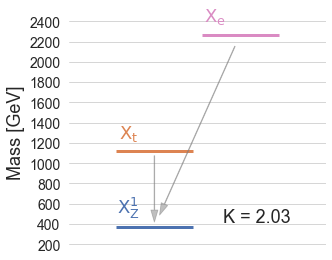

In [6]:
fig = plt.figure(figsize=figratio)
ax = plt.gca()
ax.get_xaxis().set_visible(False)


#Compute coordinates of lines and labels:
nptc = len(sortedNames)
xmin = 0.0
xmax = 1.0
dx = (xmax-xmin)/(nptc)
x0_line = xmin
coords = {}
iside = 1.0
for i,name in enumerate(sortedNames):
    mass = massesDict[name]
   
    xf_line = x0_line + lineLength*(xmax-xmin)
    y_line = mass
    
    x_label = (xf_line + x0_line)/2.
    x_label -= (xf_line - x0_line)/3 #Shift the label position to the left
    y_label = mass + 0.07*dm
    
    coords[name] = {'x_label' : x_label, 'y_label' : y_label, 
                    'x0_line' : x0_line, 'xf_line' : xf_line, 'y_line' : y_line}

    if i > 0 or nptc == 2:
        x0_line += dx

#Center particles lines within plot range:
maxx = max([c['xf_line'] for c in coords.values()])
dx = (1.0 - maxx)/2.0
for name in coords:
    for label in coords[name]:
        if 'y_' in label: continue
        coords[name][label] += dx

#Draw lines, labels and decay arrows:
for name in sortedNames:
    mass = massesDict[name]
    col = colorDict[namer.pid(name)]
    if drawMassValue:
        label = r'$\mathrm{%s}$ (%1.0f GeV)' %(name,mass)
    else:
        label = r'$\mathrm{%s}$' %(name)
        
    #Draw particle name
    t = plt.text (coords[name]['x_label'], coords[name]['y_label'], label, 
              c = col, size=labelSize, ha="center")
    
    #Draw particle line:
    plt.hlines(mass, coords[name]['x0_line'], coords[name]['xf_line'], 
               colors= col, linewidth=lineWidth)

    #Draw decay lines:
    col = colorDict[namer.pid(name)]
    if name in decaysDict and len(decaysDict[name]) > 0:
        decays = decaysDict[name]
        for dpid in decays:
            pid = dpid
            if isinstance(dpid,tuple):
                pid = [p for p in dpid if p > 10000]
                if len(pid) != 1:
                    print('Can not handle non-Z2 decays')
                    continue
                pid = pid[0]
            daughterName = namer.texName(pid)
            br = decays[dpid]
            daughterMass = massesDict[daughterName]

            x0_arrow = (coords[name]['xf_line'] + coords[name]['x0_line'])/2.
            y0_arrow = coords[name]['y_line']
            xf_arrow = (coords[daughterName]['xf_line'] + coords[daughterName]['x0_line'])/2.
            yf_arrow = coords[daughterName]['y_line']

            plt.annotate("", xy=(xf_arrow,yf_arrow), xytext=(x0_arrow,y0_arrow), arrowprops=prop)
            
            if drawBRValue:
                x_BR = 1.1*(x0_arrow+xf_arrow)/2
                y_BR = (y0_arrow+yf_arrow)/2                
                plt.annotate("%1.0f %%" %(100*br),xytext=(x_BR,y_BR),
                        xy=(x_BR,y_BR),fontsize=0.75*labelSize)

if drawKvalue:
    plt.text(0.6,0.1,r'K = %1.2f' %p.K,transform=ax.transAxes,fontsize=labelSize)
            
#Final changes:
plt.yticks(deltaM*np.arange(np.floor(minmass/deltaM),np.ceil(maxmass/deltaM)+1))
plt.xlim(xmin,xmax)
plt.ylim(min(0.99*deltaM*np.floor(minmass/deltaM),0.99*minmass),
                 max(1.01*maxmass,1.01*deltaM*np.ceil(maxmass/deltaM)+1))
plt.box(on=None)
plt.yticks(fontsize=int(0.8*labelSize))
plt.ylabel('Mass [GeV]',fontsize=int(labelSize))
plt.grid(True,axis='y')

plt.tight_layout()
plt.savefig(outputFile)
plt.show()